In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [4]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell, date):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.date = date
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    '%s: buy %d units at price %f, total balance %f'
                    % (self.date[t], buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    print('%s, nothing to do,'% (self.date[t]))
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    '%s, sell %d units at price %f, investment %f %%, total balance %f, '
                    % (self.date[t], sell_units, total_sell, invest, initial_money)
                )
            else:
                print(
                    '%s, nothing to do,'
                    % (self.date[t])
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%, hold %f units'
            % (initial_money - starting_money, invest, quantity)
        )
        
        plt.figure(figsize = (15, 5))
        
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(close, 'X', label = 'predict buy', 
                 markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'predict sell', 
                 markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

In [5]:
# data
# filename = '47#IFL8' # 沪深主连
# filename = '47#IH50' # 上证50 ???
filename = '47#IC500' # 中证500
# filename = 'NYKAU' # 纽约黄金期货价格
# filename = '30#AUL9' # 黄金指数
# filename = 'SH#601952' # SKNF

In [6]:
df = pd.read_csv('../dataset/'+filename+'.csv')
df.tail()
money = 10000 # set the parameter initmoney
if money == 10000:
    pars = ''
else:
    pars = str(money)
pars = ''
# weight
# filename = '47#IFL8' # 沪深主连
# filename = '47#IH50' # 上证50 ???
filename = '47#IC500' # 中证500
# filename = 'NYKAU' # 纽约黄金期货价格
# filename = '30#AUL9' # 黄金指数
# filename = 'SH#601952' # SKNF

In [7]:
close = df.Close.values.tolist()[-40:]
close.append(close[-1])
date = df.Date.values.tolist()[-40:]
date.append(date[-1])
window_size = 30
skip = 1
l = len(close) - 1
initial_money = money

In [8]:
model = Model(window_size, 500, 3)
model.set_weights(np.load('../log/free_agent/'+pars+filename+'_evolution_strategy_agent.npy',
                          allow_pickle=True).tolist())
agent = Agent(model, money, 5, 5, date)

2020/06/29, nothing to do,
2020/06/30, nothing to do,
2020/07/01, nothing to do,
2020/07/02, nothing to do,
2020/07/03, nothing to do,
2020/07/06, nothing to do,
2020/07/07, nothing to do,
2020/07/08, nothing to do,
2020/07/09, nothing to do,
2020/07/10, nothing to do,
2020/07/13, nothing to do,
2020/07/14, nothing to do,
2020/07/15: buy 1 units at price 6638.840000, total balance 3361.160000
2020/07/16, sell 1 units at price 6320.000000, investment -4.802646 %, total balance 9681.160000, 
2020/07/17, nothing to do,
2020/07/20, nothing to do,
2020/07/21, nothing to do,
2020/07/22, nothing to do,
2020/07/23, nothing to do,
2020/07/24: buy 5 units at price 31419.900000, total balance -21738.740000
2020/07/27, nothing to do,
2020/07/28, sell 5 units at price 31798.300000, investment 1.204332 %, total balance 10059.560000, 
2020/07/29, nothing to do,
2020/07/30, nothing to do,
2020/07/31, nothing to do,
2020/08/03, nothing to do,
2020/08/04: buy 5 units at price 33488.550000, total balance

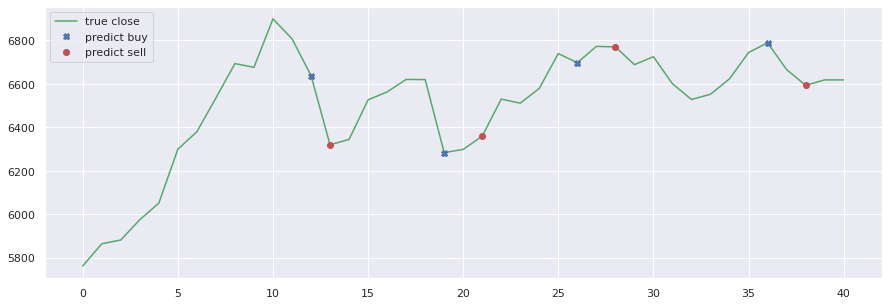

In [9]:
agent.buy()

In [10]:
print(date[-10:])

localtime = time.asctime( time.localtime(time.time()) )
print (localtime)

['2020/08/11', '2020/08/12', '2020/08/13', '2020/08/14', '2020/08/17', '2020/08/18', '2020/08/19', '2020/08/20', '2020/08/21', '2020/08/21']
Sun Aug 23 06:42:45 2020


In [11]:
pars

''